#**Swire Coca-Cola Cart Abandonment Analysis**
### MSBA Capstone  
**Author:** Alphonsinah Ototo  

---

# Table of Contents  
1. Introduction
2. Data Sources & Loading  
3. Exploratory Data Analysis  
   - Customer segmentation  
   - Ordering behavior  
   - Google Analytics usage behavior  
   - Operational cadence & cutoff times  
   - Product catalog insights  
4. Key EDA Insights  
5. Modeling Workflow  
   - Target definition  
   - Leakage handling  
   - Feature engineering  
   - Train/test split (time-based)  
6. Model Training & Evaluation  
   - Logistic regression  
   - ROC, confusion matrix, classification report  
   - Calibration & Brier score  
7. Profit-Based Threshold Optimization  
8. Final Recommendations & Next Steps  


# 1. Introduction

Swire Coca-Cola’s MyCoke360 platform enables B2B customers to browse products, place orders, and manage deliveries.  
However, many sessions involve product interaction but do not result in a completed purchase, leading to significant cart abandonment.

Cart abandonment matters because it affects:

- Lost revenue  
- Increased operational workload from manual follow-ups  
- Inefficient fulfillment planning    

This notebook contains my individual EDA and modeling work for the MSBA Capstone.  
My goal is to:

1. Understand customer behavior across several operational datasets.  
2. Identify key predictors associated with cart abandonment.  
3. Build a leakage-safe model to estimate purchase probability.  
4. Use profit-based thresholding to determine which customers are worth contacting.  

This notebook represents my personal contribution to the group project.




# 2. Data Sources & Loading

The analysis uses multiple operational datasets, including:

- **Customer master**
- **Sales orders**
- **Google Analytics event logs**
- **Operating hours & order frequency**
- **Cutoff times**
- **Product catalog**
- **Visit plan history**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
data_path = "/content/drive/MyDrive/Swire_CocaCola_Data"
os.listdir(data_path)

['visit_plan.csv',
 'sales.csv',
 ' orders.csv',
 'operating_hours.csv',
 'material.csv',
 'google_analytics.csv',
 'cutoff_times.csv',
 'customer.csv']

In [5]:
import pandas as pd

customer = pd.read_csv(data_path + "/customer.csv")
sales = pd.read_csv(data_path + "/sales.csv")
google_analytics = pd.read_csv(data_path + "/google_analytics.csv")
operating_hours = pd.read_csv(data_path + "/operating_hours.csv")
cutoff_times= pd.read_csv(data_path + "/cutoff_times.csv")
orders = pd.read_csv(data_path + "/ orders.csv")
materials = pd.read_csv(data_path + "/material.csv")
visit_plan = pd.read_csv(data_path + "/visit_plan.csv")



/tmp/ipython-input-1087114536.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  visit_plan = pd.read_csv(data_path + "/visit_plan.csv")


# 3. Exploratory Data Analysis (EDA)
This section explores customer behavior, ordering patterns, event-level engagement, and operational constraints that may contribute to cart abandonment.



In [6]:
#Preview
customer.head()

,SALES_OFFICE,CUSTOMER_NUMBER,SALES_OFFICE_DESCRIPTION,DISTRIBUTION_MODE_DESCRIPTION,SHIPPING_CONDITIONS_DESCRIPTION,COLD_DRINK_CHANNEL_DESCRIPTION,CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION
0,G111,500964906,"Draper, UT",Sideload,48 Hours,Restaurant,Dining
1,G111,501543906,"Draper, UT",Sideload,48 Hours,Restaurant,Mexican Fast Food
2,G293,501394111,"Tacoma, WA",OFS,24 Hours,Attraction,Recreation Center
3,G238,501528559,"Colorado Springs, CO",OFS,48 Hours,Attraction,Recreation Center
4,G132,500504789,"Alamosa, CO",OFS,48 Hours,Restaurant,Fast Food


In [7]:
customer.info()
customer.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   SALES_OFFICE                            6334 non-null   object
 1   CUSTOMER_NUMBER                         6334 non-null   int64 
 2   SALES_OFFICE_DESCRIPTION                6334 non-null   object
 3   DISTRIBUTION_MODE_DESCRIPTION           6330 non-null   object
 4   SHIPPING_CONDITIONS_DESCRIPTION         6334 non-null   object
 5   COLD_DRINK_CHANNEL_DESCRIPTION          6334 non-null   object
 6   CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  6334 non-null   object
dtypes: int64(1), object(6)
memory usage: 346.5+ KB


(6334, 7)

In [8]:
# Checking for missing values
customer.isnull().sum()

,0
SALES_OFFICE,0
CUSTOMER_NUMBER,0
SALES_OFFICE_DESCRIPTION,0
DISTRIBUTION_MODE_DESCRIPTION,4
SHIPPING_CONDITIONS_DESCRIPTION,0
COLD_DRINK_CHANNEL_DESCRIPTION,0
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,0


In [9]:
missing_pct = (customer['DISTRIBUTION_MODE_DESCRIPTION'].isnull().sum() / len(customer)) * 100
print(f"Missing values in DISTRIBUTION_MODE_DESCRIPTION: {missing_pct:.2f}%")

Missing values in DISTRIBUTION_MODE_DESCRIPTION: 0.06%


 The dataset contains 6,334 customers with complete information across most fields.  
Distribution mode has minimal data missing (0.06%)


In [10]:
#Dropping Null Values since they have a minimal effect on the dataset
customer = customer.dropna(subset=['DISTRIBUTION_MODE_DESCRIPTION'])

In [11]:
# Duplicates
customer.duplicated().sum()


np.int64(0)

In [12]:
# Unique values
print(customer['SALES_OFFICE'].nunique())
print(customer['SALES_OFFICE_DESCRIPTION'].nunique())
print(customer['DISTRIBUTION_MODE_DESCRIPTION'].value_counts())
print(customer['SHIPPING_CONDITIONS_DESCRIPTION'].value_counts())
print(customer['COLD_DRINK_CHANNEL_DESCRIPTION'].value_counts())
print(customer['CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION'].value_counts())



44
44
DISTRIBUTION_MODE_DESCRIPTION
OFS                     2776
Sideload                2380
Rapid Delivery          1079
Bulk Distribution         79
Full Service               6
Night Side Load            4
Night OFS                  2
Night Rapid Delivery       2
EZ Pallet                  1
Special Events             1
Name: count, dtype: int64
SHIPPING_CONDITIONS_DESCRIPTION
48 Hours             6097
24 Hours              132
Dropsite 48 Hours      59
72 Hours               41
Dropsite 24 Hours       1
Name: count, dtype: int64
COLD_DRINK_CHANNEL_DESCRIPTION
Restaurant      2960
Store            739
Hot Beverage     655
Attraction       549
Hotel            349
Institution      338
Distributor      315
Workplace        298
Clinic           127
Name: count, dtype: int64
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION
Dining                   829
Restaurant               765
Local Convenience        409
Recreation Center        371
Motel                    349
General Store            316
B

- The customer dataset represents 44 unique sales offices, showing extensive geographic coverage across Swire Coca-Cola’s operational regions.
- Distribution is dominated by OFS, Sideload, and Rapid Delivery modes, while shipping is highly standardized, with 95% of customers operating on a 48-hour delivery schedule.
- The primary cold drink channels are Restaurants and Stores
- Further segmentation reveals over 50 customer sub-trade channels, led by Dining, Restaurants, and Local Convenience Stores.

In [13]:
sales.head()

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET
0,600055574,7/17/2024,144775,130.68,22.0,737.00
1,600055574,7/17/2024,156082,37.42,6.0,105.42
2,501438989,7/17/2024,144775,41.84,4.0,166.40
3,600055574,7/17/2024,154914,53.24,4.0,123.88
4,600055574,7/17/2024,156182,110.30,10.0,348.80


/tmp/ipython-input-1105716262.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=office_counts.values, y=office_counts.index, palette="Reds_r")


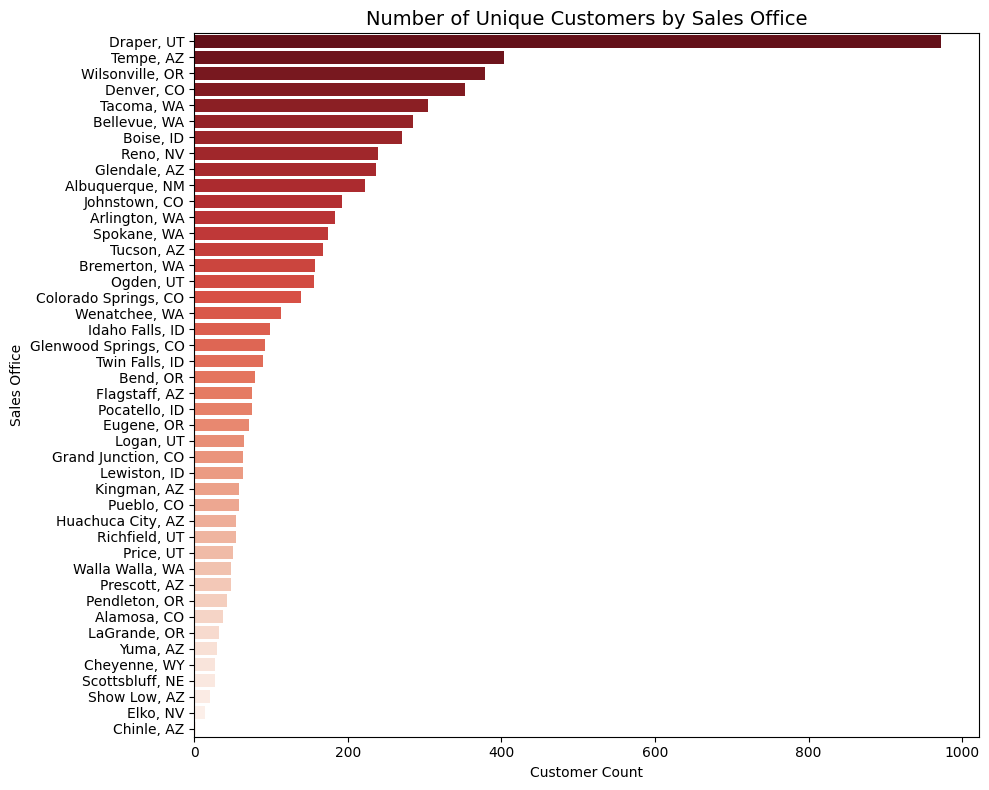

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

office_counts = (
    customer.groupby("SALES_OFFICE_DESCRIPTION")["CUSTOMER_NUMBER"]
    .nunique()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,8))
sns.barplot(x=office_counts.values, y=office_counts.index, palette="Reds_r")
plt.title("Number of Unique Customers by Sales Office", fontsize=14)
plt.xlabel("Customer Count")
plt.ylabel("Sales Office")
plt.tight_layout()
plt.show()


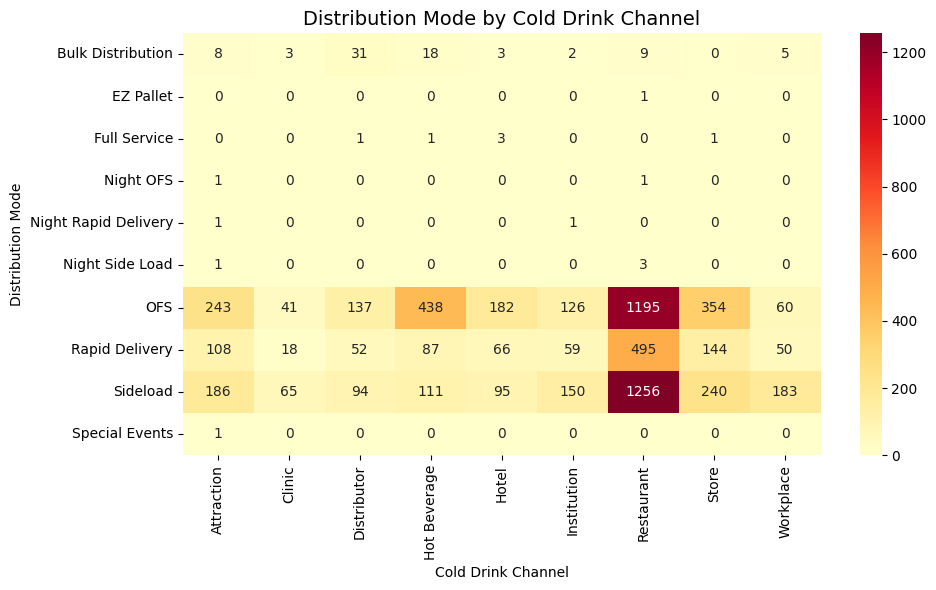

In [15]:
dist_mode_channel = pd.crosstab(
    customer['DISTRIBUTION_MODE_DESCRIPTION'],
    customer['COLD_DRINK_CHANNEL_DESCRIPTION']
)

plt.figure(figsize=(10,6))
sns.heatmap(dist_mode_channel, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Distribution Mode by Cold Drink Channel", fontsize=14)
plt.xlabel("Cold Drink Channel")
plt.ylabel("Distribution Mode")
plt.tight_layout()
plt.show()


- heatmap illustrates that OFSand Sideload are the dominant delivery modes across all cold drink channels, especially for Restaurants and Stores.
- Rapid Delivery is mainly used by Restaurants, Hot Beverage, and Attraction customers. This suggests that most customers are served through standard delivery modes, with only a few channels relying on faster or specialized logistics.

In [16]:
print(google_analytics.head())

print(google_analytics.info())
print(google_analytics.shape)


   CUSTOMER_ID  EVENT_DATE           EVENT_TIMESTAMP           EVENT_NAME  \
0    501508595  2025-04-07  2025-04-07T14:57:40.713Z  view_search_results   
1    501730915  2025-04-07  2025-04-07T19:28:54.546Z       view_item_list   
2    501567329  2025-04-07  2025-04-07T21:40:56.281Z             purchase   
3    501765083  2025-04-08  2025-04-08T06:06:36.717Z      user_engagement   
4    501707837  2025-04-08  2025-04-08T18:12:10.511Z       view_item_list   

  DEVICE_CATEGORY DEVICE_MOBILE_BRAND_NAME DEVICE_OPERATING_SYSTEM  \
0          mobile                  Samsung                 Android   
1         desktop                   Google                 Windows   
2         desktop                   Google                 Windows   
3          mobile                    Apple                     iOS   
4         desktop                   Google                 Windows   

                    EVENT_PAGE_NAME        EVENT_PAGE_TITLE  \
0                      Product List                  

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Convert EVENT_DATE and EVENT_TIMESTAMP to datetime
google_analytics['EVENT_DATE'] = pd.to_datetime(google_analytics['EVENT_DATE'])
google_analytics['EVENT_TIMESTAMP'] = pd.to_datetime(google_analytics['EVENT_TIMESTAMP'])

# Check conversion
print(google_analytics[['EVENT_DATE', 'EVENT_TIMESTAMP']].head())


  EVENT_DATE                  EVENT_TIMESTAMP
0 2025-04-07 2025-04-07 14:57:40.713000+00:00
1 2025-04-07 2025-04-07 19:28:54.546000+00:00
2 2025-04-07 2025-04-07 21:40:56.281000+00:00
3 2025-04-08 2025-04-08 06:06:36.717000+00:00
4 2025-04-08 2025-04-08 18:12:10.511000+00:00


In [18]:

# Replace google_analytics placeholders with NaN
google_analytics.replace(["(not set)", ""], np.nan, inplace=True)

# Check missing values per column
missing_summary = google_analytics.isnull().sum()
print("\nMissing values per column:")
print(missing_summary)



Missing values per column:
CUSTOMER_ID                       0
EVENT_DATE                        0
EVENT_TIMESTAMP                   0
EVENT_NAME                        0
DEVICE_CATEGORY                   0
DEVICE_MOBILE_BRAND_NAME      39468
DEVICE_OPERATING_SYSTEM           0
EVENT_PAGE_NAME             1002510
EVENT_PAGE_TITLE             318091
ITEMS                             0
dtype: int64


In [19]:
# Count duplicates before removing
print("Number of duplicate rows:", google_analytics.duplicated().sum())

# Drop duplicates
google_analytics = google_analytics.drop_duplicates()

# Confirm removal
print("Rows after removing duplicates:", len(google_analytics))


Number of duplicate rows: 688076
Rows after removing duplicates: 3016012


In [20]:
# Basic info
print("\nDataset shape:", google_analytics.shape)
print("\nData types:")
print(google_analytics.dtypes)

# Quick glance at the first few rows
print("\nHead of dataset:")
print(google_analytics.head())



Dataset shape: (3016012, 10)

Data types:
CUSTOMER_ID                               int64
EVENT_DATE                       datetime64[ns]
EVENT_TIMESTAMP             datetime64[ns, UTC]
EVENT_NAME                               object
DEVICE_CATEGORY                          object
DEVICE_MOBILE_BRAND_NAME                 object
DEVICE_OPERATING_SYSTEM                  object
EVENT_PAGE_NAME                          object
EVENT_PAGE_TITLE                         object
ITEMS                                    object
dtype: object

Head of dataset:
   CUSTOMER_ID EVENT_DATE                  EVENT_TIMESTAMP  \
0    501508595 2025-04-07 2025-04-07 14:57:40.713000+00:00   
1    501730915 2025-04-07 2025-04-07 19:28:54.546000+00:00   
2    501567329 2025-04-07 2025-04-07 21:40:56.281000+00:00   
3    501765083 2025-04-08 2025-04-08 06:06:36.717000+00:00   
4    501707837 2025-04-08 2025-04-08 18:12:10.511000+00:00   

            EVENT_NAME DEVICE_CATEGORY DEVICE_MOBILE_BRAND_NAME  \
0  vi

/tmp/ipython-input-1670705233.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


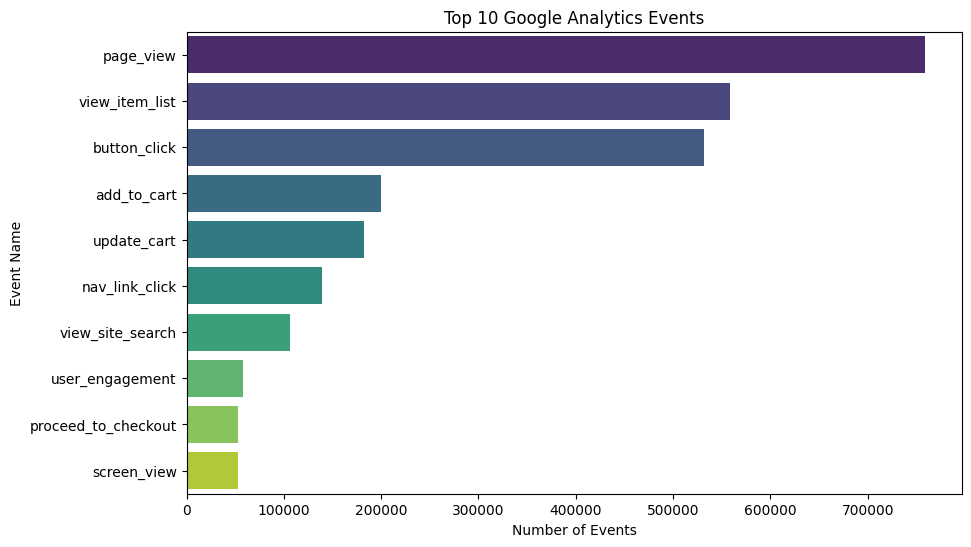

In [21]:
top_events = google_analytics['EVENT_NAME'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")
plt.title("Top 10 Google Analytics Events")
plt.xlabel("Number of Events")
plt.ylabel("Event Name")
plt.show()

- Most user interactions involve browsing such as page views, item list views, and button clicks, while fewer users progressed to transactional actions like add_to_cart and proceed_to_checkout.

In [22]:
# Device category counts
print("\nDevice categories:")
print(google_analytics['DEVICE_CATEGORY'].value_counts())

# Top mobile brands
print("\nTop 10 mobile brands:")
print(google_analytics['DEVICE_MOBILE_BRAND_NAME'].value_counts().head(10))

# Operating systems
print("\nOperating systems:")
print(google_analytics['DEVICE_OPERATING_SYSTEM'].value_counts())



Device categories:
DEVICE_CATEGORY
desktop    2433771
mobile      547738
tablet       34503
Name: count, dtype: int64

Top 10 mobile brands:
DEVICE_MOBILE_BRAND_NAME
Google            1273381
Apple              792180
Microsoft          748756
Samsung            111002
Mozilla             43526
Motorola             6396
Opera Software       4650
T-Mobile             2787
OnePlus              1368
Xiaomi                339
Name: count, dtype: int64

Operating systems:
DEVICE_OPERATING_SYSTEM
Windows      2022989
iOS           437109
Macintosh     355071
Android       145132
Chrome OS      46499
Linux           9212
Name: count, dtype: int64


- Most users access the site from desktops, primarily on Windows and Macintosh, while mobile users mainly on Google/Android and Apple/iOS make up a smaller portion.

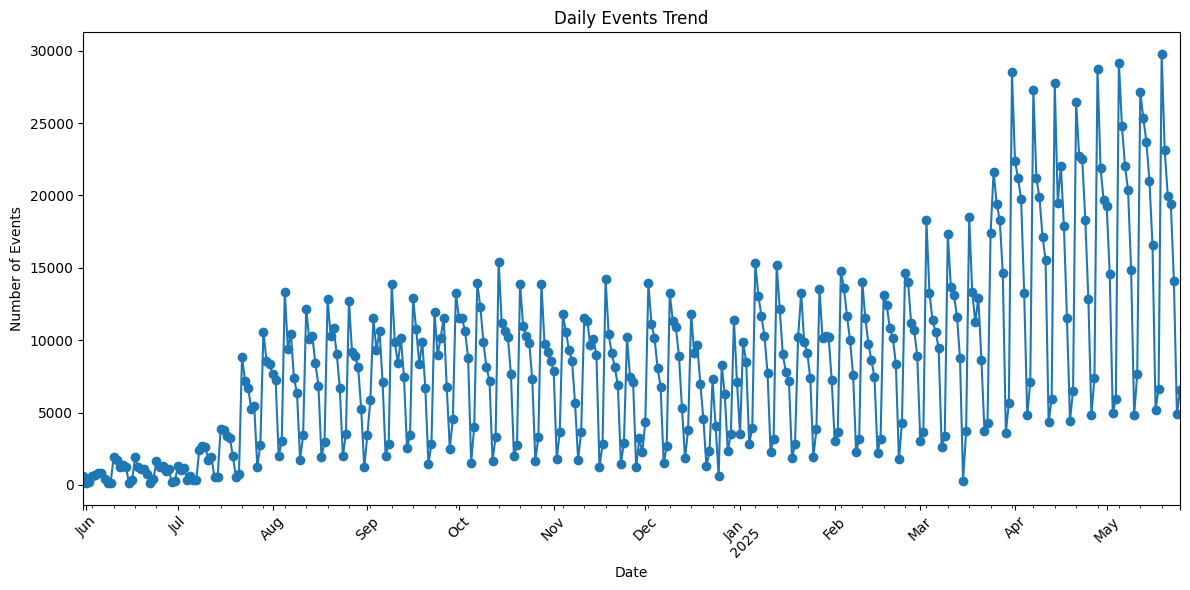

In [23]:
events_per_day = google_analytics.groupby('EVENT_DATE')['EVENT_NAME'].count()

plt.figure(figsize=(12,6))
events_per_day.plot(kind='line', marker='o')
plt.title("Daily Events Trend")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The daily events trend shows a steady increase in user activity on the MyCoke360 platform from June 2024 through May 2025
- The upward trajectory suggests growing platform adoption and higher engagement

In [24]:
print(orders.head())
print(orders.info())
print(orders.shape)

   CUSTOMER_ID CREATED_DATE_EST          CREATED_DATE_UTC  MATERIAL_ID  \
0    600265510       2025-01-10  2025-01-10T22:40:25.000Z     152965.0   
1    600584506       2024-11-22  2024-11-22T17:34:30.000Z     156127.0   
2    600686120       2024-06-04  2024-06-05T00:29:33.000Z     103886.0   
3    501087671       2024-12-03  2024-12-03T18:14:23.000Z     134926.0   
4    501680332       2025-03-31  2025-03-31T22:33:07.000Z     152196.0   

   ORDER_QUANTITY   ORDER_TYPE PLANT_ID  
0             1.0  CALL CENTER     G267  
1             1.0    SALES REP     G221  
2             1.0    SALES REP     G291  
3             2.0    SALES REP     G163  
4             1.0    SALES REP     G221  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1662157 entries, 0 to 1662156
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   CUSTOMER_ID       1662157 non-null  int64  
 1   CREATED_DATE_EST  1662157 non-null  obj

In [25]:
# Check missing values
print(orders.isnull().sum())

# Summary of duplicates
print(orders.duplicated().sum())

# Count distinct customers and products
print(orders['CUSTOMER_ID'].nunique(), orders['MATERIAL_ID'].nunique())


CUSTOMER_ID           0
CREATED_DATE_EST      0
CREATED_DATE_UTC      0
MATERIAL_ID         195
ORDER_QUANTITY        0
ORDER_TYPE            0
PLANT_ID             11
dtype: int64
847
6166 1095


In [26]:
#orders distribution
print(orders['ORDER_TYPE'].value_counts(normalize=True) * 100)


ORDER_TYPE
SALES REP        61.400578
MYCOKE360        27.372745
CALL CENTER       6.786844
MYCOKE LEGACY     3.906911
OTHER             0.305928
EDI               0.226994
Name: proportion, dtype: float64


- Most orders (61.4%) are placed through Sales Representatives, while MyCoke360 accounts for 27.4%

In [27]:
orders['ORDER_QUANTITY'].describe()

# Top ordered products
orders.groupby('MATERIAL_ID')['ORDER_QUANTITY'].sum().sort_values(ascending=False).head(10)


,ORDER_QUANTITY
MATERIAL_ID,
115583.0,197378.0
112259.0,183315.0
119826.0,143930.0
126689.0,135432.0
116366.0,124477.0
115584.0,115696.0
115586.0,86554.0
133129.0,83256.0
129254.0,78264.0


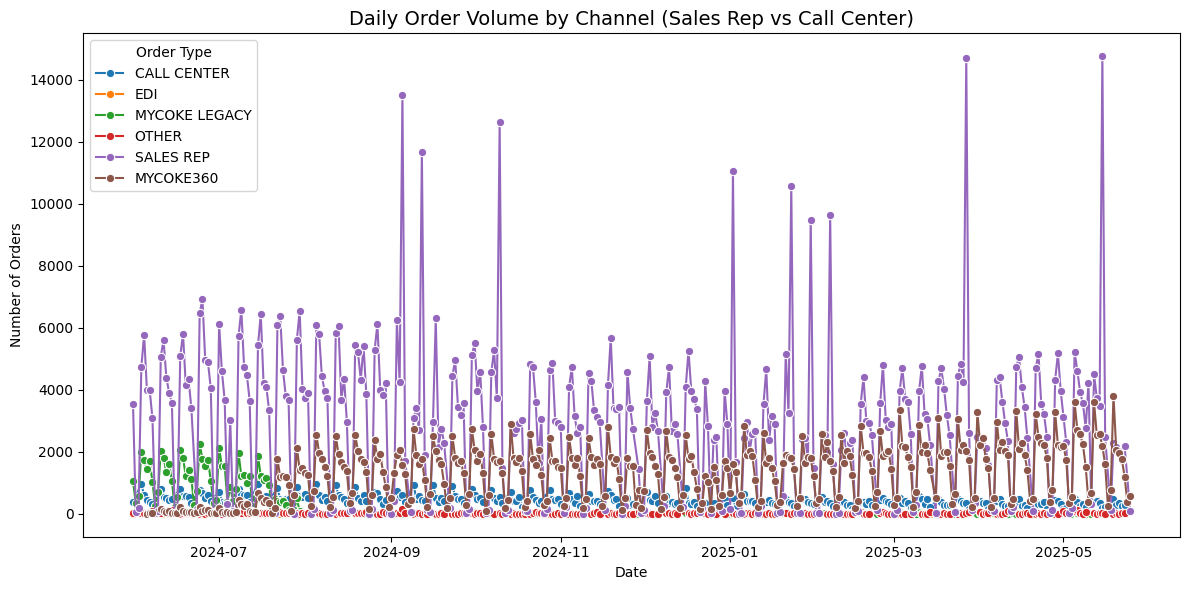

In [28]:

# Convert dates
orders['CREATED_DATE_EST'] = pd.to_datetime(orders['CREATED_DATE_EST'])

# Group by date and order type
order_trend = (
    orders.groupby(['CREATED_DATE_EST', 'ORDER_TYPE'])
    .size()
    .reset_index(name='Order_Count')
)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=order_trend,
    x='CREATED_DATE_EST',
    y='Order_Count',
    hue='ORDER_TYPE',
    marker='o'
)
plt.title('Daily Order Volume by Channel (Sales Rep vs Call Center)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend(title='Order Type')
plt.tight_layout()
plt.show()


- Sales Representatives drive the majority of daily orders, showing strong and consistent weekly peaks.

- MyCoke360 orders are steadily increasing.

In [29]:
print(operating_hours.head())

   CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
0        600069597  Every 4 Weeks              Friday            2/5/2025
1        501562126  Every 4 Weeks             Tuesday           1/26/2025
2        500324496  Every 4 Weeks             Tuesday            2/2/2025
3        600259095     Every Week           Wednesday            2/4/2025
4        501072497     Every Week             Tuesday          11/17/2024


In [30]:
import pandas as pd

# Convert dates
operating_hours['CALLING_ANCHOR_DATE'] = pd.to_datetime(operating_hours['CALLING_ANCHOR_DATE'], errors='coerce')

# Missing values
print("Missing values per column:")
print(operating_hours.isnull().sum())

# Duplicates
print("\nNumber of duplicate rows:")
print(operating_hours.duplicated().sum())
#frequency
print(operating_hours['FREQUENCY'].value_counts())

Missing values per column:
CUSTOMER_NUMBER        0
FREQUENCY              0
DELIVERY_ANCHOR_DAY    0
CALLING_ANCHOR_DATE    0
dtype: int64

Number of duplicate rows:
0
FREQUENCY
Every 4 Weeks    2562
Every Week       2140
Every 2 Weeks    1489
Every 3 Weeks      11
Name: count, dtype: int64


<Axes: title={'center': 'Operating hours Distribution '}, xlabel='FREQUENCY'>

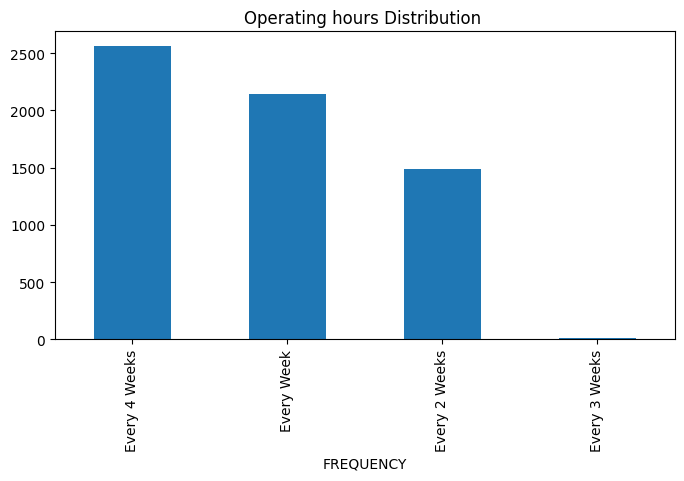

In [31]:
operating_hours['FREQUENCY'].value_counts().plot(kind='bar', figsize=(8,4), title='Operating hours Distribution ')


- Most operations occur on a regular schedule, with the majority happening every 4 weeks (2,562 records), followed by weekly operations (2,140 records), and every 2 weeks (1,489 records). Only a small portion, 11 records, follow an every 3 weeks pattern.

In [32]:
print(operating_hours['DELIVERY_ANCHOR_DAY'].value_counts())

# Crosstab: Frequency vs Day
print(pd.crosstab(operating_hours['DELIVERY_ANCHOR_DAY'], operating_hours['FREQUENCY']))


DELIVERY_ANCHOR_DAY
Wednesday    1343
Thursday     1282
Tuesday      1220
Friday       1185
Monday       1155
Sunday         15
Error           2
Name: count, dtype: int64
FREQUENCY            Every 2 Weeks  Every 3 Weeks  Every 4 Weeks  Every Week
DELIVERY_ANCHOR_DAY                                                         
Error                            1              0              0           1
Friday                         301              5            497         382
Monday                         301              1            438         415
Sunday                           1              1              2          11
Thursday                       290              3            565         424
Tuesday                        283              0            519         418
Wednesday                      312              1            541         489


- Most deliveries occur on weekdays, particularly between Tuesday and Friday, with very few scheduled for weekends

Axes(0.125,0.2;0.775x0.68)
CALLING_ANCHOR_DATE
Tuesday      1323
Monday       1305
Sunday       1221
Wednesday    1182
Saturday     1101
Thursday       39
Friday         31
Name: count, dtype: int64


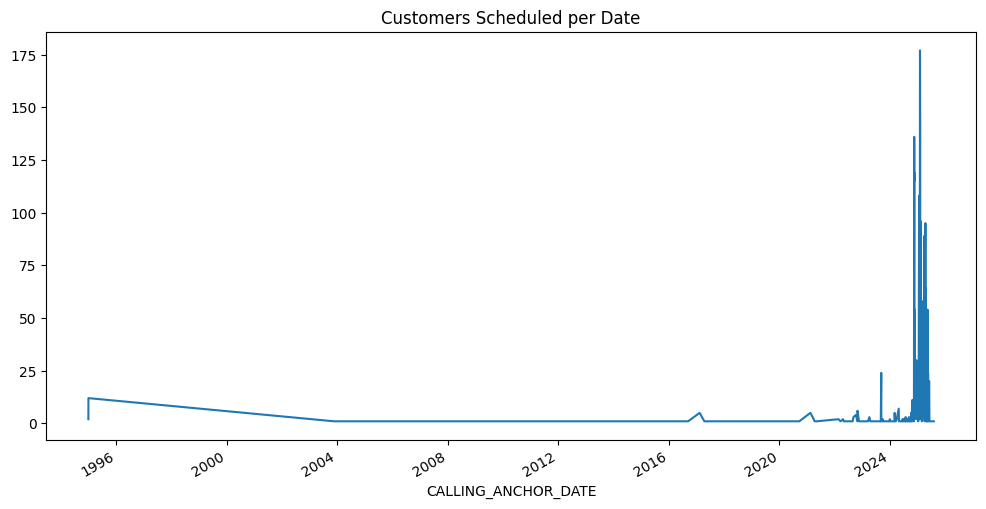

In [33]:
# Customers scheduled for each date
print(operating_hours.groupby("CALLING_ANCHOR_DATE")['CUSTOMER_NUMBER'].count().plot(figsize=(12,6), title="Customers Scheduled per Date"))

# Weekly distribution
print(operating_hours['CALLING_ANCHOR_DATE'].dt.day_name().value_counts())


- The dataset is heavily concentrated around Monday through Wednesday and Sunday, with minimal or almost no calls on Thursday and Friday.

In [34]:
# Customers with multiple delivery records
print(operating_hours.groupby("CUSTOMER_NUMBER")['CALLING_ANCHOR_DATE'].count().sort_values(ascending=False).head(10))


CUSTOMER_NUMBER
600975318    1
500245685    1
500245689    1
500245690    1
500245724    1
500245736    1
500245738    1
500245797    1
500245831    1
500245833    1
Name: CALLING_ANCHOR_DATE, dtype: int64


In [35]:
print(cutoff_times.head())
print(cutoff_times.info())
print(cutoff_times.shape)

  SALES_OFFICE PLANT_ID CUTOFFTIME__C SHIPPING_CONDITION_TIME  \
0   Draper, UT     G111    6:00:00 PM                   72hrs   
1   Draper, UT     G111    6:00:00 PM                   48hrs   
2   Draper, UT     G111    1:30:00 PM                   24hrs   
3   Draper, UT     G111    3:30:00 PM                   24hrs   
4   Draper, UT     G111    3:30:00 PM                   24hrs   

   DISTRIBUTION_MODE  
0          Tell Sell  
1          Tell Sell  
2          Tell Sell  
3                OFS  
4  Bulk Distribution  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   SALES_OFFICE             220 non-null    object
 1   PLANT_ID                 220 non-null    object
 2   CUTOFFTIME__C            220 non-null    object
 3   SHIPPING_CONDITION_TIME  220 non-null    object
 4   DISTRIBUTION_MODE        220 non-null    obj

In [36]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid")


In [37]:
# Show raw values exactly as stored
for val in cutoff_times['CUTOFFTIME__C'].head(20):
    print(repr(val))


'6:00:00 PM'
'6:00:00 PM'
'1:30:00 PM'
'3:30:00 PM'
'3:30:00 PM'
'3:30:00 PM'
'3:30:00 PM'
'1:00:00 PM'
'5:00:00 PM'
'5:00:00 PM'
'5:00:00 PM'
'1:00:00 PM'
'1:00:00 PM'
'3:00:00 PM'
'3:00:00 PM'
'3:00:00 PM'
'3:30:00 PM'
'3:30:00 PM'
'3:00:00 PM'
'3:30:00 PM'


In [38]:

cutoff_times['CUTOFFTIME_CLEAN'] = cutoff_times['CUTOFFTIME__C'].astype(str).str.strip()

# Convert to datetime
cutoff_times['CUTOFFTIME_DT'] = pd.to_datetime(cutoff_times['CUTOFFTIME_CLEAN'], errors='coerce')

# Extract only the time
cutoff_times['CUTOFFTIME_ONLY'] = cutoff_times['CUTOFFTIME_DT'].dt.time

# Check results
print("Successfully parsed times:", cutoff_times['CUTOFFTIME_ONLY'].notnull().sum())
print("Failed parsing:", cutoff_times['CUTOFFTIME_ONLY'].isnull().sum())

# Inspect first few rows
print(cutoff_times[['CUTOFFTIME__C', 'CUTOFFTIME_ONLY']].head(10))


Successfully parsed times: 220
Failed parsing: 0
  CUTOFFTIME__C CUTOFFTIME_ONLY
0    6:00:00 PM        18:00:00
1    6:00:00 PM        18:00:00
2    1:30:00 PM        13:30:00
3    3:30:00 PM        15:30:00
4    3:30:00 PM        15:30:00
5    3:30:00 PM        15:30:00
6    3:30:00 PM        15:30:00
7    1:00:00 PM        13:00:00
8    5:00:00 PM        17:00:00
9    5:00:00 PM        17:00:00


/tmp/ipython-input-4067413269.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cutoff_times['CUTOFFTIME_DT'] = pd.to_datetime(cutoff_times['CUTOFFTIME_CLEAN'], errors='coerce')


In [39]:
print(cutoff_times['CUTOFFTIME_ONLY'].value_counts().head(10))


CUTOFFTIME_ONLY
15:00:00    36
15:30:00    27
16:00:00    26
11:00:00    26
16:30:00    25
12:00:00    18
14:00:00    17
10:00:00    10
10:30:00     9
13:30:00     6
Name: count, dtype: int64


In [40]:
mode_per_plant = cutoff_times.groupby('PLANT_ID')['CUTOFFTIME_ONLY'].agg(lambda x: x.mode()[0])
print(mode_per_plant)


PLANT_ID
0       10:00:00
G111    15:30:00
G113    13:00:00
G115    15:00:00
G116    12:00:00
G121    10:00:00
G131    15:00:00
G132    15:00:00
G133    15:00:00
G141    15:00:00
G142    14:00:00
G143    11:00:00
G144    08:00:00
G151    13:00:00
G152    12:00:00
G161    12:00:00
G163    15:30:00
G164    12:00:00
G165    11:00:00
G171    12:00:00
G175    11:00:00
G181    12:00:00
G182    12:00:00
G183    14:30:00
G185    10:30:00
G221    15:30:00
G222    14:00:00
G223    11:00:00
G235    15:00:00
G236    15:00:00
G237    15:00:00
G238    14:00:00
G261    11:00:00
G262    10:30:00
G263    16:00:00
G264    10:00:00
G265    11:00:00
G267    13:30:00
G282    14:00:00
G291    11:00:00
G292    11:30:00
G293    14:00:00
G294    16:00:00
Name: CUTOFFTIME_ONLY, dtype: object


In [41]:
# Convert 'SHIPPING_CONDITION_TIME' to numeric hours
cutoff_times['SHIPPING_HOURS'] = cutoff_times['SHIPPING_CONDITION_TIME'].str.replace("hrs","").astype(int)

# Quick check
print(cutoff_times[['SHIPPING_CONDITION_TIME', 'SHIPPING_HOURS']].head())


  SHIPPING_CONDITION_TIME  SHIPPING_HOURS
0                   72hrs              72
1                   48hrs              48
2                   24hrs              24
3                   24hrs              24
4                   24hrs              24


<Axes: >

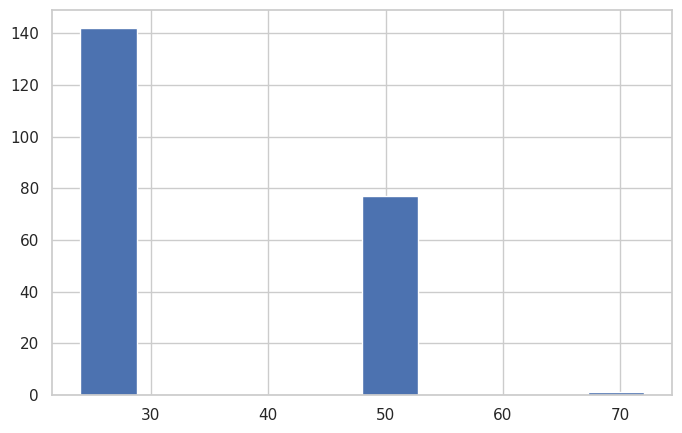

In [42]:
cutoff_times['SHIPPING_HOURS'].describe()
cutoff_times['SHIPPING_HOURS'].hist(figsize=(8,5))

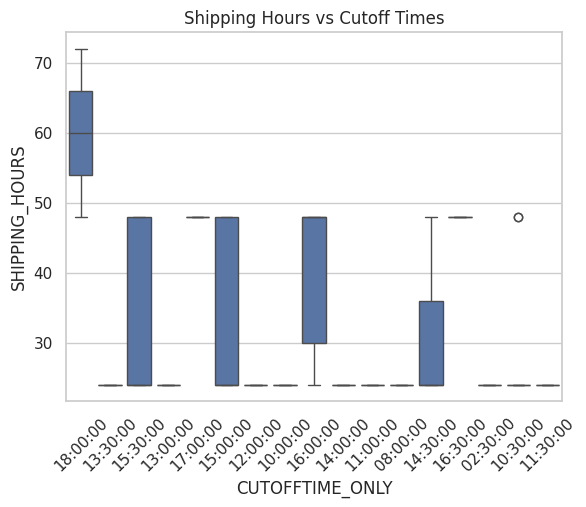

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='CUTOFFTIME_ONLY', y='SHIPPING_HOURS', data=cutoff_times)
plt.xticks(rotation=45)
plt.title("Shipping Hours vs Cutoff Times")
plt.show()

- The submission deadlines vary between 10:00 AM and 4:00 PM, with the most frequent cutoff windows occurring around 3:00 PM (36), 3:30 PM (27), and 4:00 PM (26).
- These times suggest a strong operational clustering in the mid-afternoon period.
- The earlier cutoff times are associated with shorter shipping durations (24–30 hours), whereas later cutoff times correspond to longer shipping windows (48–72 hours).
- This pattern suggests that regional variations in cutoff scheduling directly influence fulfillment efficiency, where later submission allowances tend to delay shipment cycles.

In [44]:
print(materials.head())
print(materials.info())
print(materials.shape)

   MATERIAL_ID          PACK_TYPE_DESC   TRADE_MARK_DESC    FLAVOUR_DESC  \
0       125522  Plastic Bottle - Other  Oliver Originals  Salted Caramel   
1       116974           Styrofoam Lid         Sunny Sip    Passionfruit   
2       113144              Bag-In-Box             Sam's       Bubblegum   
3       410256            Aluminum Can     Jack's Juices      Cappuccino   
4       146980            Aluminum Can  Oliver Originals   Vanilla Latte   

  PACK_SIZE_DESC    BEV_CAT_DESC  
0          20 OZ  CORE SPARKLING  
1          24 OZ             NaN  
2     2.5 GALLON  JUICES/NECTARS  
3          12 OZ  CORE SPARKLING  
4          16 OZ  CORE SPARKLING  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MATERIAL_ID      1252 non-null   int64 
 1   PACK_TYPE_DESC   1252 non-null   object
 2   TRADE_MARK_DESC  1252 non-null   object
 3

In [45]:
print(materials.isnull().sum())
print(materials.duplicated().sum())
print(materials.nunique())

MATERIAL_ID          0
PACK_TYPE_DESC       0
TRADE_MARK_DESC      0
FLAVOUR_DESC         0
PACK_SIZE_DESC       0
BEV_CAT_DESC       134
dtype: int64
0
MATERIAL_ID        1252
PACK_TYPE_DESC       20
TRADE_MARK_DESC      14
FLAVOUR_DESC        172
PACK_SIZE_DESC       59
BEV_CAT_DESC         11
dtype: int64


In [46]:
#Fill missing BEV_CAT_DESC values
materials['BEV_CAT_DESC'] = materials['BEV_CAT_DESC'].fillna('Unknown')


In [47]:
materials['BEV_CAT_DESC'].value_counts(normalize=True)*100


,proportion
BEV_CAT_DESC,
CORE SPARKLING,36.182109
ENERGY DRINKS,22.523962
SPORTS DRINKS,11.102236
Unknown,10.702875
ENHANCED WATER BEVERAGES,4.712460
PACKAGED WATER (PLAIN & ENRICHED),4.153355
FRUIT/VEGETABLE STILL DRINKS,3.833866
TEA,2.795527
OTHER NONALCOHOLIC BEVERAGES,1.916933


- The beverage portfolio is dominated by Core Sparkling products (36.2%), followed by Energy Drinks (22.5%) and Sports Drinks (11.1%), together accounting for nearly 70% of all SKUs.

Text(0.5, 1.0, 'Top 10 Brands by Product Count')

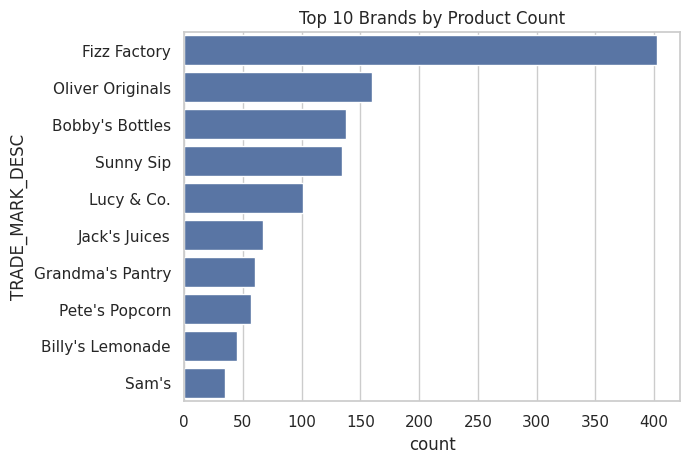

In [48]:
sns.countplot(y='TRADE_MARK_DESC', data=materials, order=materials['TRADE_MARK_DESC'].value_counts().head(10).index)
plt.title('Top 10 Brands by Product Count')


In [49]:
pd.crosstab(materials['BEV_CAT_DESC'], materials['PACK_TYPE_DESC'])


PACK_TYPE_DESC,Aluminum Bottle,Aluminum Can,Aluminum Can - SLIIM,Aluminum Cup,Bag-In-Box,CO2 Tank,Glass Bottle - Contour,Glass Bottle - Other,Glass Bottle - Dimple,Other,Paper Cup,Plastic Bottle - Contour,Plastic Bottle - Dimple,Plastic Bottle - Other,Plastic Cartridge,Plastic Cup,Plastic Lid,Plastic Pouch,Styrofoam Cup,Styrofoam Lid
BEV_CAT_DESC,,,,,,,,,,,,,,,,,,,,
COFFEE PACKAGED,0,3,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
CORE SPARKLING,0,97,56,0,89,0,8,16,4,0,0,66,28,85,4,0,0,0,0,0
DAIRY/SOY BEVERAGES,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0
ENERGY DRINKS,0,232,49,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENHANCED WATER BEVERAGES,0,12,0,0,7,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0
FRUIT/VEGETABLE STILL DRINKS,0,7,0,0,29,0,0,0,0,0,0,0,0,11,1,0,0,0,0,0
JUICES/NECTARS,0,0,0,0,4,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0
OTHER NONALCOHOLIC BEVERAGES,0,0,0,0,17,3,0,0,0,0,0,0,0,0,4,0,0,0,0,0
PACKAGED WATER (PLAIN & ENRICHED),2,6,11,0,2,0,0,11,0,0,0,0,0,20,0,0,0,0,0,0


In [50]:
print(visit_plan.head())
print(visit_plan.info())
print(visit_plan.shape)

   CUSTOMER_ID FREQUENCY                    ELT_TS SNAPSHOT_DATE ANCHOR_DATE  \
0    500405850        02  2021-12-14T05:49:54.551Z    2021-12-13  2020-07-20   
1    500286563        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-11-04   
2    600057832        01  2021-12-14T05:49:54.551Z    2021-12-13  2021-08-02   
3    500431853        01  2021-12-14T05:49:54.551Z    2021-12-13  2020-04-06   
4    600076074        01  2021-12-14T05:49:54.551Z    2021-12-13  2019-06-07   

  SALES_OFFICE     SALES_OFFICE_DESC DISTRIBUTION_MODE  \
0         G133  Glenwood Springs, CO                SL   
1         G236            Denver, CO                OF   
2         G111            Draper, UT                SL   
3         G111            Draper, UT                SL   
4         G142         Pocatello, ID                EZ   

  SHIPPING_CONDITIONS_DESC  
0                 48 Hours  
1                 48 Hours  
2                 48 Hours  
3                 48 Hours  
4                 24 Hour

In [51]:
print(visit_plan.isnull().sum())
print(visit_plan.duplicated().sum())
print(visit_plan.nunique())


CUSTOMER_ID                     0
FREQUENCY                   13961
ELT_TS                          0
SNAPSHOT_DATE                   0
ANCHOR_DATE                 13962
SALES_OFFICE                   74
SALES_OFFICE_DESC              74
DISTRIBUTION_MODE           15296
SHIPPING_CONDITIONS_DESC       74
dtype: int64
2701845
CUSTOMER_ID                 6334
FREQUENCY                     32
ELT_TS                      9467
SNAPSHOT_DATE               1378
ANCHOR_DATE                 2012
SALES_OFFICE                  44
SALES_OFFICE_DESC             44
DISTRIBUTION_MODE             11
SHIPPING_CONDITIONS_DESC       6
dtype: int64


<Axes: title={'center': 'Distribution of Visit Frequencies'}, xlabel='FREQUENCY'>

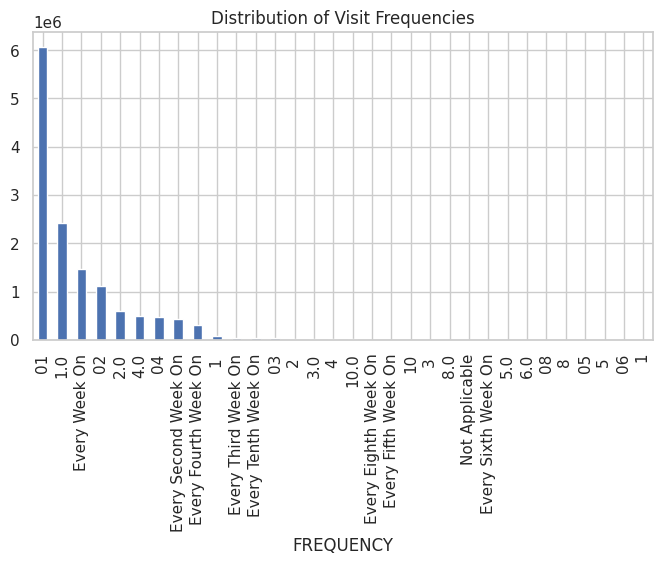

In [52]:
visit_plan['FREQUENCY'].value_counts().plot(kind='bar', figsize=(8,4), title='Distribution of Visit Frequencies')


- The majority of customers are visited weekly

- Less frequent visits (bi-weekly, monthly, or quarterly) occur for smaller or lower-volume customers

Text(0.5, 1.0, 'Top 10 Sales Offices by Planned Visits')

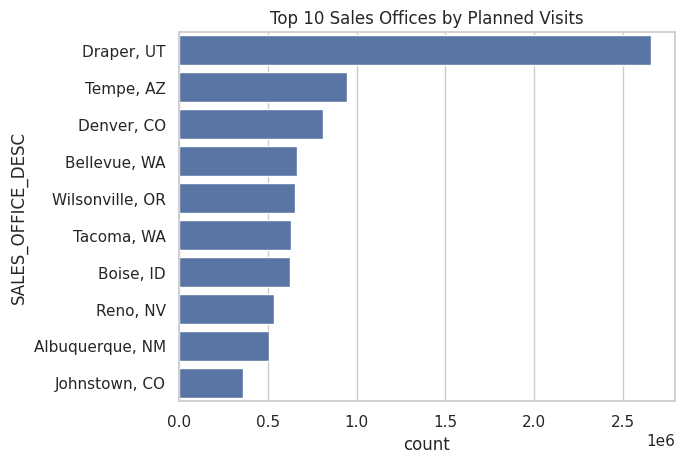

In [53]:
sns.countplot(y='SALES_OFFICE_DESC', data=visit_plan,
              order=visit_plan['SALES_OFFICE_DESC'].value_counts().head(10).index)
plt.title('Top 10 Sales Offices by Planned Visits')


- Draper, UT handles the highest number of planned visits,over 2.5 million, followed by Tempe, AZ and Denver, showing these are major operational hubs.
- Top offices likely serve the largest customer bases or most active routes,

In [54]:
pd.crosstab(visit_plan['DISTRIBUTION_MODE'], visit_plan['SHIPPING_CONDITIONS_DESC'])


SHIPPING_CONDITIONS_DESC,24 Hours,48 Hours,72 Hours,Dropsite 24 Hours,Dropsite 48 Hours,Dropsite 72 Hours
DISTRIBUTION_MODE,,,,,,
BK,92645,127271,1598,0,395,0
DD,144,0,0,0,0,0
EZ,951,2960,0,0,0,0
FS,3782,27103,7058,0,0,0
NO,0,4512,0,0,0,0
NR,0,5874,0,0,0,0
NS,0,11480,0,0,0,0
OF,556226,4862046,57947,443,12853,109
RD,31943,2221593,4306,0,2582,0


- Most deliveries use 48-hour shipping, dominated by Sideload (SL), Off-Floor (OF), and Route Delivery (RD) modes, showing these as the main distribution channels.

- 24-hour shipments occur less frequently and are concentrated in Route Delivery and Sideload, indicating faster service for select regions or customers.

# 4. Key EDA Insights

- The EDA revealed strong operational consistency across Swire Coca-Cola’s network, with most customers served weekly through 48-hour shipping windows dominated by Sideload and Off-Floor modes.
- Desktop usage is dominant; mobile activity is less frequent.  
- Distribution modes (OFS, Sideload) strongly influence ordering patterns.  
- Cutoff times cluster around mid-afternoon, creating pressure that may lead to incomplete orders.  
- Sales Representatives handled the majority of orders, while MyCoke360 showed growing digital adoption.
- Google Analytics indicated high browsing engagement but lower checkout conversion, supporting the cart abandonment concern.

 Overall, there is clear behavioral and logistical patterns,providing foundation for predicting at-risk customers and improving order completion on the MyCoke360 platform.

# 5. Modeling

## Target Definition  
The target variable made_a_purchase equals 1 if an order was completed in the defined window.

## Leakage Handling  
To ensure valid predictions, I removed all features that may contain leakage, including:  
- Purchase success indicators  
- Completion timestamps  
- Post-checkout event pages  
- Flags explicitly encoding purchase outcome  

## Feature Engineering  
Key features engineered include:
- Time features (hour, day-of-week, month)  
- Device category indicators  
- Event-level behavioral signals (add_to_cart, remove_from_cart, etc.)  
- Item count extracted from JSON lists  

##  Train/Test Split  
To simulate real deployment, I used a **time-based split**:
- First 75% of events → training  
- Last 25% → holdout testing  


In [55]:

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Loading modelling dataset
file_path = "/content/drive/MyDrive/Final Output for Modeling .csv"
df = pd.read_csv(file_path)

print("Raw shape:", df.shape)
display(df.head())

df.info()
print("\nMissing values per column:")
print(df.isna().sum())

display(df.describe(include='all').transpose())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw shape: (211, 15)


,CUSTOMER_ID,transaction_date_df2,event_date_df1,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS,made_a_purchase,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE
0,501009474,2024-06-04 18:00:00,2024-06-04,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,1.0,122366.0,3.0,MYCOKE LEGACY
1,501009474,2024-06-11 18:00:00,2024-06-16,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,1.0,126582.0,1.0,MYCOKE LEGACY
2,501009474,2024-06-18 18:00:00,2024-06-16,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,1.0,122360.0,3.0,MYCOKE LEGACY
3,501009474,2024-07-02 18:00:00,2024-07-04,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,1.0,138334.0,1.0,MYCOKE LEGACY
4,501009474,2024-07-09 18:00:00,2024-07-04,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,not available given order type,1.0,122366.0,6.0,MYCOKE LEGACY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CUSTOMER_ID               211 non-null    int64  
 1   transaction_date_df2      211 non-null    object 
 2   event_date_df1            211 non-null    object 
 3   EVENT_TIMESTAMP           211 non-null    object 
 4   EVENT_NAME                211 non-null    object 
 5   DEVICE_CATEGORY           211 non-null    object 
 6   DEVICE_MOBILE_BRAND_NAME  211 non-null    object 
 7   DEVICE_OPERATING_SYSTEM   211 non-null    object 
 8   EVENT_PAGE_NAME           211 non-null    object 
 9   EVENT_PAGE_TITLE          211 non-null    object 
 10  ITEMS                     211 non-null    object 
 11  made_a_purchase           211 non-null    float64
 12  MATERIAL_ID               211 non-null    object 
 13  ORDER_QUANTITY            211 non-null    object 
 14  ORDER_TYPE

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUSTOMER_ID,211.0,NaN,NaN,NaN,548335771.14218,49518116.887635,501009474.0,501473692.0,501641934.0,600077289.0,600686511.0
transaction_date_df2,211,175,2024-06-04 18:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_date_df1,211,140,2024-12-13,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENT_TIMESTAMP,211,132,not available given order type,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENT_NAME,211,14,not available given order type,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEVICE_CATEGORY,211,4,desktop,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEVICE_MOBILE_BRAND_NAME,211,5,not available given order type,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEVICE_OPERATING_SYSTEM,211,5,Windows,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENT_PAGE_NAME,211,10,not available given order type,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENT_PAGE_TITLE,211,22,not available given order type,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:

import ast

#Normalize placeholder strings to NaN
PLACEHOLDERS = {
    "not available given order type",
    "not available",
    "NA", "N/A", "None", "", "null", "NULL"
}

df_clean = df.copy()

for col in df_clean.columns:
    if df_clean[col].dtype == "object":
        df_clean[col] = df_clean[col].replace(list(PLACEHOLDERS), np.nan)

# Parse datetime columns if present
def to_dt(x):
    return pd.to_datetime(x, errors="coerce")

dt_cols = ["transaction_date_df2", "event_date_df1", "EVENT_TIMESTAMP"]
for c in dt_cols:
    if c in df_clean.columns:
        df_clean[c] = to_dt(df_clean[c])

# Coerce numeric candidates
def to_num(s):
    return pd.to_numeric(s, errors="coerce")

num_candidates = ["ORDER_QUANTITY", "MATERIAL_ID"]
for c in num_candidates:
    if c in df_clean.columns and df_clean[c].dtype == "object":
        df_clean[c] = to_num(df_clean[c])

# define target
if "made_a_purchase" not in df_clean.columns:
    raise ValueError("Expected 'made_a_purchase' column as target.")
df_clean["made_a_purchase"] = df_clean["made_a_purchase"].fillna(0).astype(int)

print("Cleaned frame shape:", df_clean.shape)
df_clean[["made_a_purchase"]].value_counts(normalize=True).rename("proportion")


Cleaned frame shape: (211, 15)


,proportion
made_a_purchase,
1,0.606635
0,0.393365


In [57]:
#Feature Engineering

#Transaction-based time features
if "transaction_date_df2" in df_clean.columns:
    df_clean["trans_dow"] = df_clean["transaction_date_df2"].dt.dayofweek
    df_clean["trans_hour"] = df_clean["transaction_date_df2"].dt.hour
    df_clean["trans_month"] = df_clean["transaction_date_df2"].dt.month
    df_clean["trans_is_weekend"] = df_clean["trans_dow"].isin([5, 6]).astype(int)

# Event-based date/time features
if "event_date_df1" in df_clean.columns:
    df_clean["event_dow"] = df_clean["event_date_df1"].dt.dayofweek
    df_clean["event_month"] = df_clean["event_date_df1"].dt.month
if "EVENT_TIMESTAMP" in df_clean.columns:
    df_clean["event_hour"] = df_clean["EVENT_TIMESTAMP"].dt.hour

# ITEMS feature
def items_count(val):
    if pd.isna(val):
        return np.nan
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list):
            return len(parsed)
    except Exception:
        pass
    return np.nan

if "ITEMS" in df_clean.columns and df_clean["ITEMS"].dtype == "object":
    df_clean["items_count"] = df_clean["ITEMS"].apply(items_count)

# Device/channel features
if "DEVICE_CATEGORY" in df_clean.columns:
    df_clean["is_mobile"] = df_clean["DEVICE_CATEGORY"].isin(["mobile", "tablet"]).astype(int)
    df_clean["is_desktop"] = (df_clean["DEVICE_CATEGORY"] == "desktop").astype(int)

# Event action flags
if "EVENT_NAME" in df_clean.columns:
    df_clean["evt_add_to_cart"] = (df_clean["EVENT_NAME"] == "add_to_cart").astype(int)
    df_clean["evt_begin_checkout"] = df_clean["EVENT_NAME"].isin(
        ["begin_checkout", "proceed_to_checkout"]
    ).astype(int)
    df_clean["evt_purchase"] = (df_clean["EVENT_NAME"] == "purchase").astype(int)
    df_clean["evt_remove_from_cart"] = (df_clean["EVENT_NAME"] == "remove_from_cart").astype(int)

print("After feature engineering:", df_clean.shape)
display(df_clean.head())


After feature engineering: (211, 29)


,CUSTOMER_ID,transaction_date_df2,event_date_df1,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,...,event_dow,event_month,event_hour,items_count,is_mobile,is_desktop,evt_add_to_cart,evt_begin_checkout,evt_purchase,evt_remove_from_cart
0,501009474,2024-06-04 18:00:00,2024-06-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,1,6,NaN,NaN,0,0,0,0,0,0
1,501009474,2024-06-11 18:00:00,2024-06-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,NaN,NaN,0,0,0,0,0,0
2,501009474,2024-06-18 18:00:00,2024-06-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,NaN,NaN,0,0,0,0,0,0
3,501009474,2024-07-02 18:00:00,2024-07-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,3,7,NaN,NaN,0,0,0,0,0,0
4,501009474,2024-07-09 18:00:00,2024-07-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,3,7,NaN,NaN,0,0,0,0,0,0


In [58]:
# Addressing Obvious Leakage

# Dropping columns that directly encode success / outcome / post-purchase info
possible_leakage_cols = [
    'purchase_successful',
    'EVENT_PAGE_NAME',
    'checkout_result',
    'order_status',
    'completed_flag',
    'transaction_id',
    'final_order_value',
    'payment_success',
    'is_converted',
    'order_complete_flag',
    'converted',
    'purchase_timestamp',
    'abandoned_in_window',
    'events_full_window',
    'actions_after_deadline',
    'evt_purchase',
]

df_clean = df_clean.drop(
    columns=[c for c in possible_leakage_cols if c in df_clean.columns],
    errors="ignore"
)

print("Columns after dropping obvious leakage:")
print(sorted(df_clean.columns))

# Removing explicit purchase rows from event-level data
work = df_clean.copy()

if "EVENT_NAME" in work.columns:
    work = work[work["EVENT_NAME"].ne("purchase")]

# Also rows whose event page looks like a success page
if "EVENT_PAGE_NAME" in work.columns:
    work = work[~work["EVENT_PAGE_NAME"].fillna("").str.contains("purchase success", case=False)]

# Making sure target stays intact
work["made_a_purchase"] = work["made_a_purchase"].fillna(0).astype(int)

print("Leak-filtered working frame shape:", work.shape)
display(work.head())


Columns after dropping obvious leakage:
['CUSTOMER_ID', 'DEVICE_CATEGORY', 'DEVICE_MOBILE_BRAND_NAME', 'DEVICE_OPERATING_SYSTEM', 'EVENT_NAME', 'EVENT_PAGE_TITLE', 'EVENT_TIMESTAMP', 'ITEMS', 'MATERIAL_ID', 'ORDER_QUANTITY', 'ORDER_TYPE', 'event_date_df1', 'event_dow', 'event_hour', 'event_month', 'evt_add_to_cart', 'evt_begin_checkout', 'evt_remove_from_cart', 'is_desktop', 'is_mobile', 'items_count', 'made_a_purchase', 'trans_dow', 'trans_hour', 'trans_is_weekend', 'trans_month', 'transaction_date_df2']
Leak-filtered working frame shape: (192, 27)


,CUSTOMER_ID,transaction_date_df2,event_date_df1,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_TITLE,ITEMS,...,trans_is_weekend,event_dow,event_month,event_hour,items_count,is_mobile,is_desktop,evt_add_to_cart,evt_begin_checkout,evt_remove_from_cart
0,501009474,2024-06-04 18:00:00,2024-06-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,6,NaN,NaN,0,0,0,0,0
1,501009474,2024-06-11 18:00:00,2024-06-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,6,NaN,NaN,0,0,0,0,0
2,501009474,2024-06-18 18:00:00,2024-06-16,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,6,NaN,NaN,0,0,0,0,0
3,501009474,2024-07-02 18:00:00,2024-07-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0,3,7,NaN,NaN,0,0,0,0,0
4,501009474,2024-07-09 18:00:00,2024-07-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0,3,7,NaN,NaN,0,0,0,0,0


In [59]:
#Modeling Frame
# categorical features
safe_categorical = [c for c in [
    "EVENT_NAME",
    "DEVICE_CATEGORY",
    "DEVICE_MOBILE_BRAND_NAME",
    "DEVICE_OPERATING_SYSTEM",
    "ORDER_TYPE",
] if c in work.columns]

# engineered numeric features
safe_numeric = [c for c in [
    "items_count",
    "trans_dow", "trans_hour", "trans_month", "trans_is_weekend",
    "event_dow", "event_hour", "event_month",
    "is_mobile", "is_desktop",
    "evt_add_to_cart", "evt_begin_checkout", "evt_remove_from_cart"
] if c in work.columns]

id_cols = [c for c in ["CUSTOMER_ID"] if c in work.columns]

cols_needed = (
    id_cols +
    (["event_date_df1"] if "event_date_df1" in work.columns else []) +
    safe_categorical + safe_numeric +
    ["made_a_purchase"]
)

df_leakfree = work[cols_needed].copy()

print("Leak-safe modeling frame shape:", df_leakfree.shape)
print("\nTarget distribution (made_a_purchase):")
print(df_leakfree["made_a_purchase"].value_counts(normalize=True).rename("proportion"))

display(df_leakfree.head())


Leak-safe modeling frame shape: (192, 21)

Target distribution (made_a_purchase):
made_a_purchase
1    0.567708
0    0.432292
Name: proportion, dtype: float64


,CUSTOMER_ID,event_date_df1,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,ORDER_TYPE,items_count,trans_dow,trans_hour,...,trans_is_weekend,event_dow,event_hour,event_month,is_mobile,is_desktop,evt_add_to_cart,evt_begin_checkout,evt_remove_from_cart,made_a_purchase
0,501009474,2024-06-04,NaN,NaN,NaN,NaN,MYCOKE LEGACY,NaN,1,18,...,0,1,NaN,6,0,0,0,0,0,1
1,501009474,2024-06-16,NaN,NaN,NaN,NaN,MYCOKE LEGACY,NaN,1,18,...,0,6,NaN,6,0,0,0,0,0,1
2,501009474,2024-06-16,NaN,NaN,NaN,NaN,MYCOKE LEGACY,NaN,1,18,...,0,6,NaN,6,0,0,0,0,0,1
3,501009474,2024-07-04,NaN,NaN,NaN,NaN,MYCOKE LEGACY,NaN,1,18,...,0,3,NaN,7,0,0,0,0,0,1
4,501009474,2024-07-04,NaN,NaN,NaN,NaN,MYCOKE LEGACY,NaN,1,18,...,0,3,NaN,7,0,0,0,0,0,1


In [60]:
#Train/Test Split (Time-Based Holdout)

from sklearn.model_selection import GroupKFold, KFold
import pandas.api.types as ptypes

# Separate X and y
X = df_leakfree.drop(
    columns=["made_a_purchase", "event_date_df1"] if "event_date_df1" in df_leakfree.columns else ["made_a_purchase"]
)
y = df_leakfree["made_a_purchase"].copy()

# Group labels
groups = df_leakfree["CUSTOMER_ID"] if "CUSTOMER_ID" in df_leakfree.columns else None

# Time-based holdout: last 25% by event_date_df1; fallback to index order
if "event_date_df1" in df_leakfree.columns and ptypes.is_datetime64_any_dtype(df_leakfree["event_date_df1"]):
    order_idx = np.argsort(df_leakfree["event_date_df1"].values)
    cutoff = int(len(order_idx) * 0.75)
    train_idx, test_idx = order_idx[:cutoff], order_idx[cutoff:]
else:
    cutoff = int(len(X) * 0.75)
    train_idx, test_idx = np.arange(cutoff), np.arange(cutoff, len(X))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx] if groups is not None else None

print("Train/Test shapes:", X_train.shape, X_test.shape)
print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True).rename("proportion"))


Train/Test shapes: (144, 19) (48, 19)

Target distribution (train):
made_a_purchase
1    0.611111
0    0.388889
Name: proportion, dtype: float64


# 6. Model Training & Evaluation

 Logistic regression model was trained using a preprocessed pipeline that handles:
- Imputation  
- One-hot encoding of categorical variables  
- Scaling numeric features  

The model was evaluated using:
- Cross-validated ROC-AUC  
- Time-based holdout ROC-AUC  
- Confusion matrix  
- Classification report  


In [61]:
#Logistic Regression Pipeline + CV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# categorical vs numeric columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if X_train[c].dtype != "object"]

categorical_preprocess = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

numeric_preprocess = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

preproc = ColumnTransformer([
    ("cat", categorical_preprocess, cat_cols),
    ("num", numeric_preprocess, num_cols)
], remainder="drop")

logit = Pipeline([
    ("prep", preproc),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# Cross-validation on TRAIN
if groups_train is not None:
    gkf = GroupKFold(n_splits=5)
    cv_scores = cross_val_score(
        logit, X_train, y_train,
        cv=gkf.split(X_train, y_train, groups_train),
        scoring="roc_auc"
    )
else:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(logit, X_train, y_train, cv=kf, scoring="roc_auc")

print("Logistic CV ROC-AUC:", np.round(cv_scores, 3), "Mean:", round(cv_scores.mean(), 3))

# Fit on TRAIN and evaluate on time-based TEST
logit.fit(X_train, y_train)
y_prob = logit.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("\nTime-based Test ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Logistic CV ROC-AUC: [1.    0.889 0.963 0.87  0.902] Mean: 0.925

Time-based Test ROC-AUC: 0.883

Confusion Matrix:
 [[26  1]
 [ 8 13]]

Classification Report:
               precision    recall  f1-score   support

           0      0.765     0.963     0.852        27
           1      0.929     0.619     0.743        21

    accuracy                          0.812        48
   macro avg      0.847     0.791     0.798        48
weighted avg      0.836     0.812     0.805        48



Time-based Test ROC-AUC: 0.883


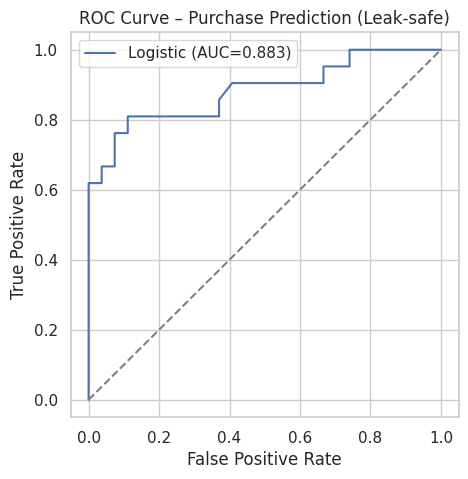

Brier score (model): 0.1223
Brier score (baseline, always = avg rate 0.611): 0.2762


In [62]:
#  ROC Curve, Brier Score & Calibration

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("Time-based Test ROC-AUC:", round(roc_auc, 3))

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"Logistic (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Purchase Prediction (Leak-safe)")
plt.grid(True)
plt.legend()
plt.show()

# Brier score
brier_model = brier_score_loss(y_test, y_prob)
base_prob = y_train.mean()
brier_baseline = brier_score_loss(y_test, np.full_like(y_test, fill_value=base_prob, dtype=float))

print("Brier score (model):", round(brier_model, 4))
print("Brier score (baseline, always = avg rate {:.3f}): {:.4f}".format(base_prob, brier_baseline))


# 7. Profit-Based Threshold Optimization

While classification metrics are useful, Our real objective is **recovering revenue **.  
Using assumptions for:
- Cost per contact  
- Expected profit per recovered purchase  

I computed net profit across thresholds from 0.01–0.99.  
The optimal threshold maximizes expected profit and provides a deployable decision rule.


Best threshold by net profit:


,2
threshold,0.050000
tp,21.000000
fp,20.000000
fn,0.000000
tn,7.000000
n_targeted,41.000000
revenue,1050.000000
cost,41.000000
net_profit,1009.000000
net_profit_per_1000,21020.833333


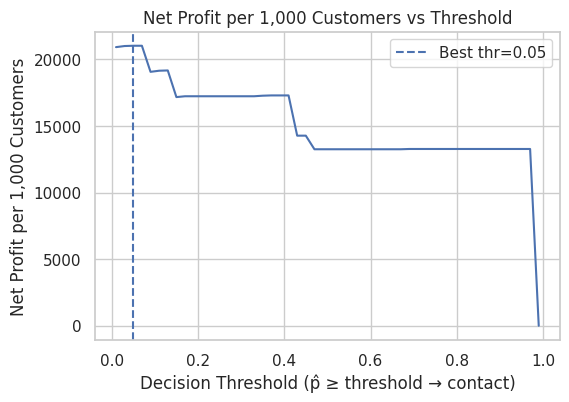

In [63]:
# Profit-Based Threshold Tuning
from sklearn.metrics import confusion_matrix

# Assumptions
cost_per_contact = 1.0
profit_per_purchase = 50.0
def profit_curve(y_true, y_prob, cost_per_contact, profit_per_purchase, n_thresholds=50):
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    rows = []
    n = len(y_true)
    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n_targeted = tp + fp

        revenue = tp * profit_per_purchase
        cost = n_targeted * cost_per_contact
        net_profit = revenue - cost
        profit_per_1000 = (net_profit / n) * 1000

        rows.append({
            "threshold": thr,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "n_targeted": n_targeted,
            "revenue": revenue,
            "cost": cost,
            "net_profit": net_profit,
            "net_profit_per_1000": profit_per_1000
        })
    return pd.DataFrame(rows)

profit_df = profit_curve(y_test.values, y_prob, cost_per_contact, profit_per_purchase)
best_row = profit_df.loc[profit_df["net_profit"].idxmax()]

print("Best threshold by net profit:")
display(best_row)

plt.figure(figsize=(6,4))
plt.plot(profit_df["threshold"], profit_df["net_profit_per_1000"])
plt.axvline(best_row["threshold"], linestyle="--", label=f"Best thr={best_row['threshold']:.2f}")
plt.title("Net Profit per 1,000 Customers vs Threshold")
plt.xlabel("Decision Threshold (p̂ ≥ threshold → contact)")
plt.ylabel("Net Profit per 1,000 Customers")
plt.grid(True)
plt.legend()
plt.show()


# 9. Final Recommendations & Next Steps

- Target customers above the optimal probability threshold for outreach, maximizing revenue recovery.  
- Focus user-experience improvements on the most common drop-off points identified in GA events.    
- Consider A/B testing different outreach strategies for customers at varying risk levels.  
